PROMETHEE

In [167]:
import pandas as pd 
import numpy as np
import matplotlib as plt
import networkx as nx
from matplotlib.patches import Rectangle
from copy import deepcopy

In [168]:
data_pd = pd.read_csv('dane.csv')

In [169]:
models = list(data_pd['Nazwa'])

In [170]:
data_pd = data_pd.drop(['Nazwa'], axis=1)

In [171]:
data = data_pd.to_numpy()

In [172]:
q_g=[3, 6, 5, 0.5, 0, 1, 10, 50]
p_g=[15, 20, 15, 1, 10, 5, 30, 200]
weights_g=[0.15, 0.1, 0.2, 0.1, 0.05, 0.15, 0.5, 0.2]

In [173]:
data.shape

(19, 8)

In [174]:
# mnożenie przez -1 dla optymalizacji obliczeń kryterium typu koszt
data[:,3] *= -1
data[:,6] *= -1
data[:,7] *= -1

In [175]:
pi_i=np.zeros((data.shape[0],data.shape[0],data.shape[1]))

In [176]:
pi_i.shape

(19, 19, 8)

In [177]:
pi=np.zeros((data.shape[0],data.shape[0]))

In [178]:
for g in range(data.shape[1]):
    d = np.subtract.outer(data[:, g], data[:, g])  # Różnice między wszystkimi kombinacjami par
    pi_i[:, :, g] = np.where(d > p_g[g], 1, np.where(d <= q_g[g], 0, (d - q_g[g]) / (p_g[g] - q_g[g])))

In [179]:
pi = np.sum(weights_g * pi_i, axis=2) / np.sum(weights_g)

In [180]:
fi_positive=np.sum(pi, axis=1)
fi_negative=np.sum(pi, axis=0)

In [181]:
fi_positive

array([ 6.43218391,  9.30666141,  7.5228243 , 10.15471264,  3.5270936 ,
        4.39241379,  4.00311987,  5.24633826,  5.11622332,  4.18995074,
        7.79208539,  2.75402299,  3.10821018,  6.43472906,  9.32633826,
        6.21852217,  5.41297209,  8.75921182,  2.19668309])

In [182]:
fi_negative

array([ 5.84482759,  1.78778325,  4.96790739,  1.89310345, 10.31474548,
        7.63878489,  6.80295567,  4.80197044,  5.05001642,  7.63530378,
        2.97554286,  9.53349754,  9.41133005,  4.91898194,  2.84541872,
        5.65714286,  7.24689655,  2.70749688,  9.86059113])

In [183]:
fi_complete=fi_positive-fi_negative

In [184]:
# Explaining the preference information for ELECTRE III and PROMETHEE
print("Preference Information:")
print("Weights (importance) of criteria:", weights_g)
print("Preference thresholds (p_g):", p_g)
print("Indifference thresholds (q_g):", q_g)

Preference Information:
Weights (importance) of criteria: [0.15, 0.1, 0.2, 0.1, 0.05, 0.15, 0.5, 0.2]
Preference thresholds (p_g): [15, 20, 15, 1, 10, 5, 30, 200]
Indifference thresholds (q_g): [3, 6, 5, 0.5, 0, 1, 10, 50]


In [185]:
# Calculating rankings for PROMETHEE I and II
fi_positive=np.sum(pi, axis=1)  # Outflows
fi_negative=np.sum(pi, axis=0)  # Inflows
fi_complete=fi_positive-fi_negative  # Net flows

# Printing results
print("PROMETHEE I Positive Flow Ranking:")
print(np.argsort(-fi_positive)+1)
print("PROMETHEE I Negative Flow Ranking:")
print(np.argsort(fi_negative)+1)
print("PROMETHEE II Net Flow Ranking:")
print(np.argsort(-fi_complete)+1)


PROMETHEE I Positive Flow Ranking:
[ 4 15  2 18 11  3 14  1 16 17  8  9  6 10  7  5 13 12 19]
PROMETHEE I Negative Flow Ranking:
[ 2  4 18 15 11  8 14  3  9 16  1  7 17 10  6 13 12 19  5]
PROMETHEE II Net Flow Ranking:
[ 4  2 15 18 11  3 14  1 16  8  9 17  7  6 10 13 12  5 19]


In [186]:
def determine_relations(positive_flow, negative_flow):
    num_of_headphones = len(positive_flow)
    P_matrix = np.zeros((num_of_headphones, num_of_headphones), dtype=int)
    R_matrix = np.zeros((num_of_headphones, num_of_headphones), dtype=int)

    better_strength = np.greater(positive_flow[:, np.newaxis], positive_flow)  
    equal_strength = np.equal(positive_flow[:, np.newaxis], positive_flow)  
    better_weakness = np.less(negative_flow[:, np.newaxis], negative_flow)  
    equal_weakness = np.equal(negative_flow[:, np.newaxis], negative_flow)  

    P_matrix[(better_strength & (equal_weakness | better_weakness)) | (better_weakness & (equal_strength | better_strength))] = 1
    R_matrix[((positive_flow[:, np.newaxis] == positive_flow) & (negative_flow[:, np.newaxis] == negative_flow))] = 1

    return P_matrix, R_matrix

P_matrix, R_matrix = determine_relations(fi_positive, fi_negative)


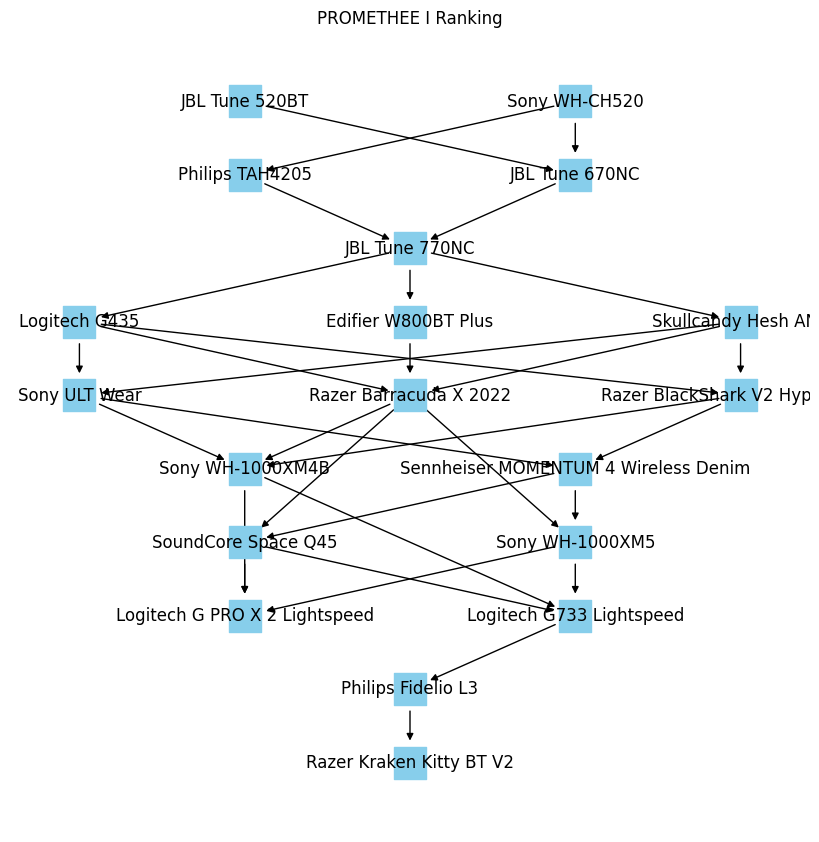

In [187]:
import matplotlib.pyplot as plt
import networkx as nx

def generate_graph(variants, P_matrix):
    G = nx.DiGraph()
    index_to_headphone = {i: headphone for i, headphone in enumerate(variants)}

    incoming_edges = [0] * len(variants)
    for i in range(len(variants)):
        for j in range(len(variants)):
            if P_matrix[i][j] == 1:
                incoming_edges[j] += 1

    layers = []
    process_queue = [i for i in range(len(variants)) if incoming_edges[i] == 0]
    next_queue = []

    while process_queue:
        layers.append(process_queue)
        for i in process_queue:
            for j in range(len(variants)):
                if P_matrix[i][j] == 1:
                    incoming_edges[j] -= 1
                    if incoming_edges[j] == 0:
                        next_queue.append(j)
        process_queue, next_queue = next_queue, []

    for i in range(len(variants)):
        for j in range(len(variants)):
            if P_matrix[i][j] == 1:
                G.add_edge(index_to_headphone[i], index_to_headphone[j])

    return G, layers, index_to_headphone

def draw_promethe_1_diagram(G, layers, index_to_headphone):
    TR = nx.transitive_reduction(G)
    pos = {}
    for layer_index, layer in enumerate(layers):
        x_offsets = range(len(layer))
        for i, x_offset in zip(layer, x_offsets):
            pos[index_to_headphone[i]] = (x_offset - len(layer) / 2, -layer_index)

    plt.figure(figsize=(8, 8)) 
    nx.draw(TR, pos, with_labels=True, node_shape='s', node_color='skyblue', node_size=500, font_size=12, edge_color='k')
    plt.title('PROMETHEE I Ranking')
    plt.axis('off')  
    plt.show()

def promethe_1_diagram(variants, P_matrix):
    G, layers, index_to_headphone = generate_graph(variants, P_matrix)
    draw_promethe_1_diagram(G, layers, index_to_headphone)

# Example usage:
promethe_1_diagram(models, P_matrix)


ELECTREE

In [188]:
data = data_pd.to_numpy()
v_g=[50, 100, 120, 5, 30, 90, 300, 1000]

In [189]:
c_i = np.zeros((data.shape[0], data.shape[0], data.shape[1]))
d_i = np.zeros((data.shape[0], data.shape[0], data.shape[1]))

In [190]:
for g in range(data.shape[1]):
    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            if g == 3 or g == 6 or g == 7:
                if data[i,g]-data[j,g] <= q_g[g]:
                    c_i[i,j,g] = 1
                elif data[i,g]-data[j,g] > p_g[g]:
                    c_i[i,j,g] = 0
                else:
                    c_i[i,j,g]=(p_g[g]-(data[i,g]-data[j,g]))/(p_g[g]-q_g[g])              
            else:
                if data[i,g]-data[j,g] >= -q_g[g]:
                    c_i[i,j,g] = 1
                elif data[i,g]-data[j,g] < -p_g[g]:
                    c_i[i,j,g] = 0
                else:
                    c_i[i,j,g]=(p_g[g]-(data[j,g]-data[i,g]))/(p_g[g]-q_g[g])

In [191]:
c = np.sum(weights_g * c_i, axis=2) / np.sum(weights_g)
sigma=np.zeros((data.shape[0], data.shape[0]))
for i in range(data.shape[0]):
    for j in range(data.shape[0]):
        sigma_a_b=c[i,j]
        for g in range(data.shape[1]):
            if d_i[i,j,g]>c[i,j]:
                sigma_a_b*=(1-d_i[i,j,g])/(1-c[i,j])
        sigma[i,j]=sigma_a_b

In [192]:
def max_element_length(rank):
    return max(len(item['model']) for item in rank)

In [193]:

def destilation(sigma, variants, desc, upper_thr=None, depth=0):
    assert isinstance(variants, list)
    rankling = []
    depth += 1
    s = lambda x: -0.15 * x + 0.3

    while sigma.shape[0]>0:
        n = sigma.shape[0]
        sigma_copy = deepcopy(sigma)

        if upper_thr is None:
            mask = np.eye(n, dtype=bool)
            masked_arr = np.ma.masked_array(sigma, mask)
            upper_thr = np.max(masked_arr)
        elif upper_thr == 0:
            if len(rankling) != 1:
                rankling.append(deepcopy(variants))
            return rankling
            
        match len(variants):
            case 0:
                return rankling
            case 1:
                rankling.append(deepcopy(variants))
                return rankling
        
        if np.any(sigma < upper_thr - s(upper_thr)):
            lower_thr = np.max(sigma[sigma < upper_thr - s(upper_thr)])
        else:
            lower_thr = 0

        mask = (sigma > lower_thr) & (sigma > sigma.T + s(upper_thr))
        sigma_copy[~mask] = 0


        q = np.count_nonzero(sigma_copy, axis=1) - np.count_nonzero(sigma_copy, axis=0)

        if desc:
            indices = np.where(q == np.max(q))[0]
        else:
            indices = np.where(q == np.min(q))[0]

        if len(indices) == 1:
            if desc:
                index = indices[0]
            else:
                index = indices[-1]
            rankling.append(deepcopy(variants[index]))
            variants.pop(index)
            sigma = np.delete(sigma, index, axis=0)
            sigma = np.delete(sigma, index, axis=1)

        else:
            inner_sigma = deepcopy(sigma_copy[indices][:, indices])
            inner_rankling = destilation(inner_sigma, list(deepcopy(variants[i]) for i in indices), desc, lower_thr, depth)
            inner_var = []

            for inner_list in inner_rankling:
                if not isinstance(inner_list, list):
                    inner_list = [inner_list]
                for variant in inner_list:
                    try:
                        if desc:
                            inner_var.append(variants.index(variant))
                        else:
                            inner_var.insert(0, variants.index(variant))
                    except Exception as e:
                        continue  # Pomijaj, jeśli wariant nie został znaleziony


            inner_var = sorted(inner_var, reverse=True)
            for internal_index in inner_var:
                variants.pop(internal_index)

            sigma = np.delete(sigma, np.array(inner_var), axis=0)
            sigma = np.delete(sigma, np.array(inner_var), axis=1)

            rankling.extend(inner_rankling)

        if sigma.shape[0] == 0:
            return rankling

des_dest = destilation(sigma, deepcopy(models), True)

asc_dest = destilation(sigma, deepcopy(models), False)[::-1]

In [194]:
des_dest

['JBL Tune 520BT',
 'Sony WH-CH520',
 'JBL Tune 670NC',
 ['JBL Tune 770NC'],
 ['Philips TAH4205', 'Razer BlackShark V2 HyperSpeed'],
 'Skullcandy Hesh ANC',
 'Razer Barracuda X 2022',
 'Edifier W800BT Plus',
 'Sony ULT Wear',
 'SoundCore Space Q45',
 ['Logitech G435', 'Sennheiser MOMENTUM 4 Wireless Denim'],
 'Razer Kraken Kitty BT V2',
 ['Logitech G PRO X 2 Lightspeed',
  'Sony WH-1000XM4B',
  'Sony WH-1000XM5',
  'Philips Fidelio L3',
  'Logitech G733 Lightspeed']]

In [195]:
asc_dest

[['JBL Tune 520BT',
  'Sony WH-CH520',
  'Philips TAH4205',
  'Razer BlackShark V2 HyperSpeed'],
 'JBL Tune 670NC',
 'JBL Tune 770NC',
 ['Sony ULT Wear', 'Sennheiser MOMENTUM 4 Wireless Denim'],
 'Skullcandy Hesh ANC',
 ['Logitech G435', 'SoundCore Space Q45', 'Edifier W800BT Plus'],
 'Razer Barracuda X 2022',
 'Sony WH-1000XM5',
 'Logitech G PRO X 2 Lightspeed',
 'Sony WH-1000XM4B',
 'Philips Fidelio L3',
 'Logitech G733 Lightspeed',
 'Razer Kraken Kitty BT V2']

In [196]:
list(zip(enumerate(models)))

[((0, 'Sony ULT Wear'),),
 ((1, 'JBL Tune 520BT'),),
 ((2, 'Logitech G435'),),
 ((3, 'Sony WH-CH520'),),
 ((4, 'Logitech G PRO X 2 Lightspeed'),),
 ((5, 'SoundCore Space Q45'),),
 ((6, 'Sony WH-1000XM4B'),),
 ((7, 'Edifier W800BT Plus'),),
 ((8, 'Razer Barracuda X 2022'),),
 ((9, 'Sony WH-1000XM5'),),
 ((10, 'JBL Tune 770NC'),),
 ((11, 'Philips Fidelio L3'),),
 ((12, 'Logitech G733 Lightspeed'),),
 ((13, 'Skullcandy Hesh ANC'),),
 ((14, 'Philips TAH4205'),),
 ((15, 'Razer BlackShark V2 HyperSpeed'),),
 ((16, 'Sennheiser MOMENTUM 4 Wireless Denim'),),
 ((17, 'JBL Tune 670NC'),),
 ((18, 'Razer Kraken Kitty BT V2'),)]

In [197]:
sigma

array([[1.        , 0.34482759, 0.44827586, 0.44827586, 0.8362069 ,
        0.67241379, 1.        , 0.86206897, 0.86206897, 1.        ,
        0.46551724, 0.79310345, 0.82758621, 0.5       , 0.44827586,
        0.62931034, 0.81034483, 0.34482759, 0.86206897],
       [0.85517241, 1.        , 0.92118227, 0.93103448, 0.85221675,
        0.84482759, 0.94581281, 0.96551724, 0.96551724, 0.9408867 ,
        0.86206897, 0.93103448, 0.91625616, 0.92551724, 0.95862069,
        0.72413793, 0.81034483, 0.89655172, 0.96551724],
       [0.68965517, 0.69056552, 1.        , 0.47816092, 0.80172414,
        0.81034483, 0.75862069, 0.67586207, 0.7862069 , 0.75862069,
        0.75862069, 0.72413793, 0.86206897, 0.74448276, 0.58045977,
        0.62931034, 0.69704433, 0.75862069, 0.82758621],
       [0.80172414, 0.89655172, 0.93965517, 1.        , 0.86206897,
        0.81896552, 0.93965517, 0.93965517, 0.93965517, 1.        ,
        0.8362069 , 0.93965517, 0.90517241, 0.93965517, 0.93103448,
        0.793

In [198]:
des_dest

['JBL Tune 520BT',
 'Sony WH-CH520',
 'JBL Tune 670NC',
 ['JBL Tune 770NC'],
 ['Philips TAH4205', 'Razer BlackShark V2 HyperSpeed'],
 'Skullcandy Hesh ANC',
 'Razer Barracuda X 2022',
 'Edifier W800BT Plus',
 'Sony ULT Wear',
 'SoundCore Space Q45',
 ['Logitech G435', 'Sennheiser MOMENTUM 4 Wireless Denim'],
 'Razer Kraken Kitty BT V2',
 ['Logitech G PRO X 2 Lightspeed',
  'Sony WH-1000XM4B',
  'Sony WH-1000XM5',
  'Philips Fidelio L3',
  'Logitech G733 Lightspeed']]

In [199]:
asc_dest

[['JBL Tune 520BT',
  'Sony WH-CH520',
  'Philips TAH4205',
  'Razer BlackShark V2 HyperSpeed'],
 'JBL Tune 670NC',
 'JBL Tune 770NC',
 ['Sony ULT Wear', 'Sennheiser MOMENTUM 4 Wireless Denim'],
 'Skullcandy Hesh ANC',
 ['Logitech G435', 'SoundCore Space Q45', 'Edifier W800BT Plus'],
 'Razer Barracuda X 2022',
 'Sony WH-1000XM5',
 'Logitech G PRO X 2 Lightspeed',
 'Sony WH-1000XM4B',
 'Philips Fidelio L3',
 'Logitech G733 Lightspeed',
 'Razer Kraken Kitty BT V2']

In [200]:
print("Preference Information:")
print("Weights (importance) of criteria:", weights_g)
print("Preference thresholds (p_g):", p_g)
print("Indifference thresholds (q_g):", q_g)
print("Veto thresholds (v_g) for ELECTRE III:", v_g)

Preference Information:
Weights (importance) of criteria: [0.15, 0.1, 0.2, 0.1, 0.05, 0.15, 0.5, 0.2]
Preference thresholds (p_g): [15, 20, 15, 1, 10, 5, 30, 200]
Indifference thresholds (q_g): [3, 6, 5, 0.5, 0, 1, 10, 50]
Veto thresholds (v_g) for ELECTRE III: [50, 100, 120, 5, 30, 90, 300, 1000]


Porównanie

In [201]:
labels = models

In [202]:
# Sortowanie danych dla czytelniejszego wykresu
sorted_indices = np.argsort(-fi_positive)
sorted_labels_positive = [labels[i] for i in sorted_indices]
sorted_positive_flows = fi_positive[sorted_indices]

sorted_indices_neg = np.argsort(fi_negative)
sorted_labels_negative = [labels[i] for i in sorted_indices_neg]
sorted_negative_flows = -fi_negative[sorted_indices_neg]

sorted_indices_net = np.argsort(-fi_complete)
sorted_labels_net = [labels[i] for i in sorted_indices_net]
sorted_net_flows = fi_complete[sorted_indices_net]


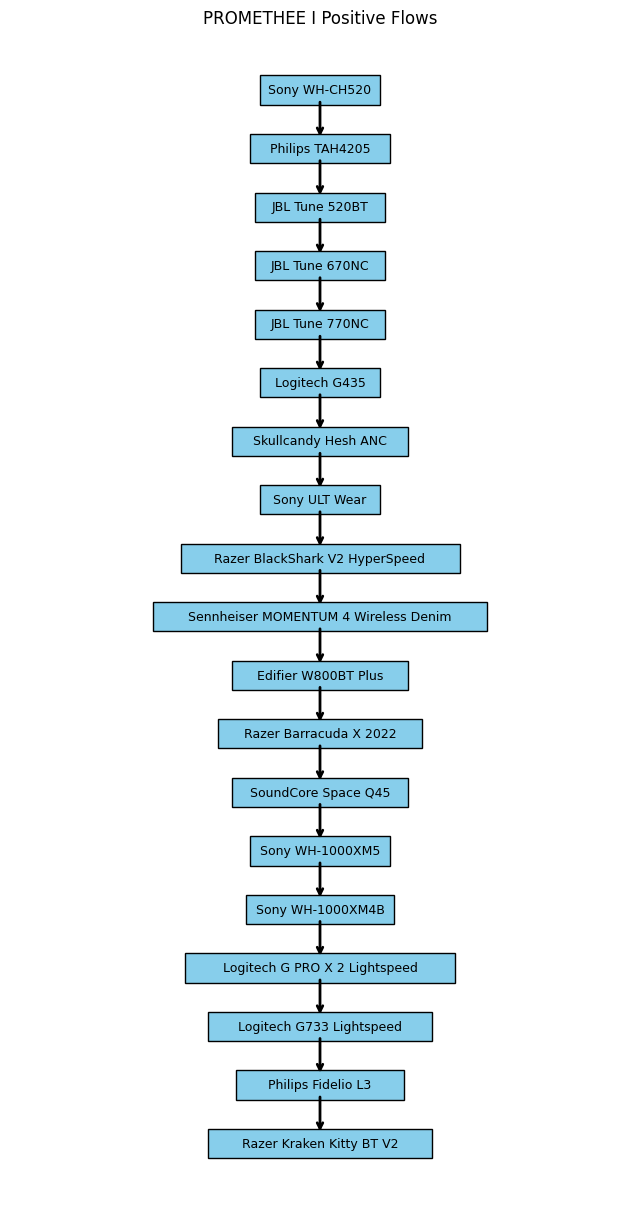

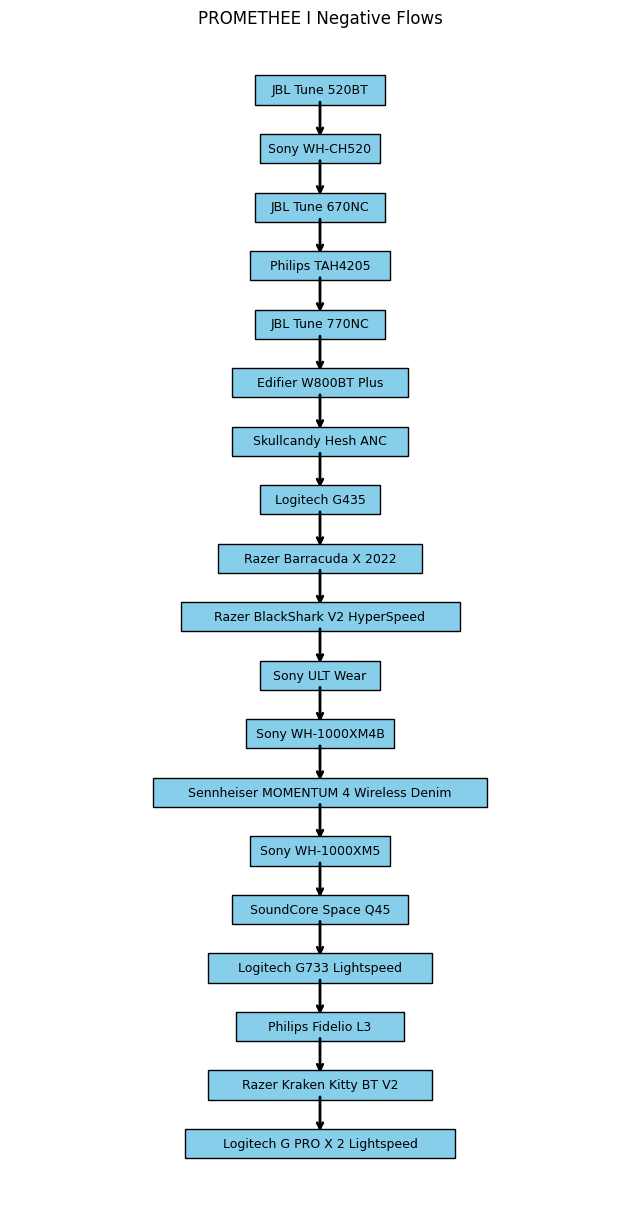

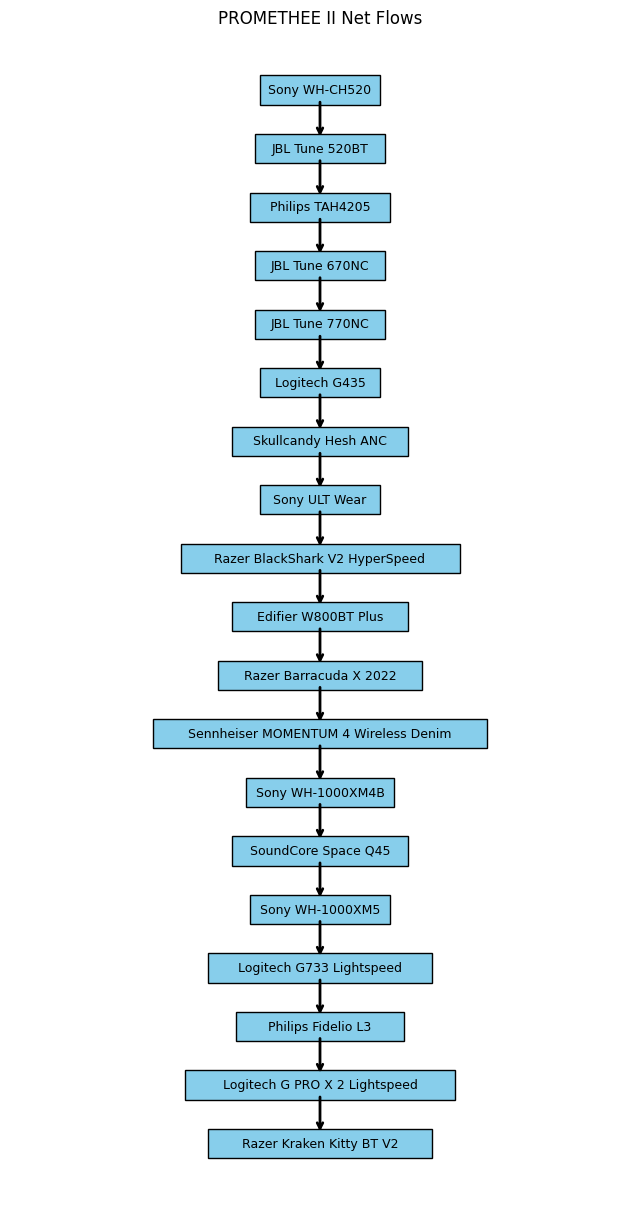

In [203]:
def set_style():
    plt.style.use('fivethirtyeight')  # Set consistent plot styling

def draw_ranking_graph(title, labels, values, spacing=1):
    G = nx.DiGraph()

    # Sorting labels and values
    sorted_indices = np.argsort(-np.array(values))  # Sort descending for most visualizations
    sorted_labels = [labels[i] for i in sorted_indices]
    corrected_labels = [label.replace(" / ", "\n") for label in sorted_labels]

    # Define node positions for a vertical layout
    pos = {label: (0, -i * spacing) for i, label in enumerate(corrected_labels)}


    for label in corrected_labels:
        G.add_node(label)
        
    for i in range(len(corrected_labels) - 1):
        G.add_edge(corrected_labels[i], corrected_labels[i + 1])
    fig, ax = plt.subplots(figsize=(8, 0.8 * len(sorted_labels) * spacing))

    for node, (x, y) in pos.items():
        text_width = len(node) * 0.03 
        rect_height = 0.5  
        rect_x = x - text_width / 2
        rect_y = y - rect_height / 2
        ax.add_patch(Rectangle((rect_x, rect_y), width=text_width, height=rect_height, color='skyblue', ec='black'))
        plt.text(x, y, node, ha='center', va='center', fontsize=9)

    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, width=2)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-len(sorted_labels) * spacing, 1)

    plt.title(title)
    plt.axis('off') 
    plt.show()


draw_ranking_graph('PROMETHEE I Positive Flows', sorted_labels_positive, sorted_positive_flows)
draw_ranking_graph('PROMETHEE I Negative Flows', sorted_labels_negative, sorted_negative_flows)
draw_ranking_graph('PROMETHEE II Net Flows', sorted_labels_net, sorted_net_flows)


In [204]:
def flatten_with_grouping(nested_list):
    """ Flatten a list while keeping certain groups as single concatenated entries """
    flat_list = []
    for element in nested_list:
        if isinstance(element, list):
            grouped_entry = " / ".join(element)
            flat_list.append(grouped_entry)
        else:
            flat_list.append(element)
    return flat_list

asc_labels_grouped = flatten_with_grouping(asc_dest)
des_labels_grouped = flatten_with_grouping(des_dest)

print("Grouped and Flattened Ascending Labels:", asc_labels_grouped)
print("Grouped and Flattened Descending Labels:", des_labels_grouped)


Grouped and Flattened Ascending Labels: ['JBL Tune 520BT / Sony WH-CH520 / Philips TAH4205 / Razer BlackShark V2 HyperSpeed', 'JBL Tune 670NC', 'JBL Tune 770NC', 'Sony ULT Wear / Sennheiser MOMENTUM 4 Wireless Denim', 'Skullcandy Hesh ANC', 'Logitech G435 / SoundCore Space Q45 / Edifier W800BT Plus', 'Razer Barracuda X 2022', 'Sony WH-1000XM5', 'Logitech G PRO X 2 Lightspeed', 'Sony WH-1000XM4B', 'Philips Fidelio L3', 'Logitech G733 Lightspeed', 'Razer Kraken Kitty BT V2']
Grouped and Flattened Descending Labels: ['JBL Tune 520BT', 'Sony WH-CH520', 'JBL Tune 670NC', 'JBL Tune 770NC', 'Philips TAH4205 / Razer BlackShark V2 HyperSpeed', 'Skullcandy Hesh ANC', 'Razer Barracuda X 2022', 'Edifier W800BT Plus', 'Sony ULT Wear', 'SoundCore Space Q45', 'Logitech G435 / Sennheiser MOMENTUM 4 Wireless Denim', 'Razer Kraken Kitty BT V2', 'Logitech G PRO X 2 Lightspeed / Sony WH-1000XM4B / Sony WH-1000XM5 / Philips Fidelio L3 / Logitech G733 Lightspeed']


In [205]:
des_labels_grouped

['JBL Tune 520BT',
 'Sony WH-CH520',
 'JBL Tune 670NC',
 'JBL Tune 770NC',
 'Philips TAH4205 / Razer BlackShark V2 HyperSpeed',
 'Skullcandy Hesh ANC',
 'Razer Barracuda X 2022',
 'Edifier W800BT Plus',
 'Sony ULT Wear',
 'SoundCore Space Q45',
 'Logitech G435 / Sennheiser MOMENTUM 4 Wireless Denim',
 'Razer Kraken Kitty BT V2',
 'Logitech G PRO X 2 Lightspeed / Sony WH-1000XM4B / Sony WH-1000XM5 / Philips Fidelio L3 / Logitech G733 Lightspeed']

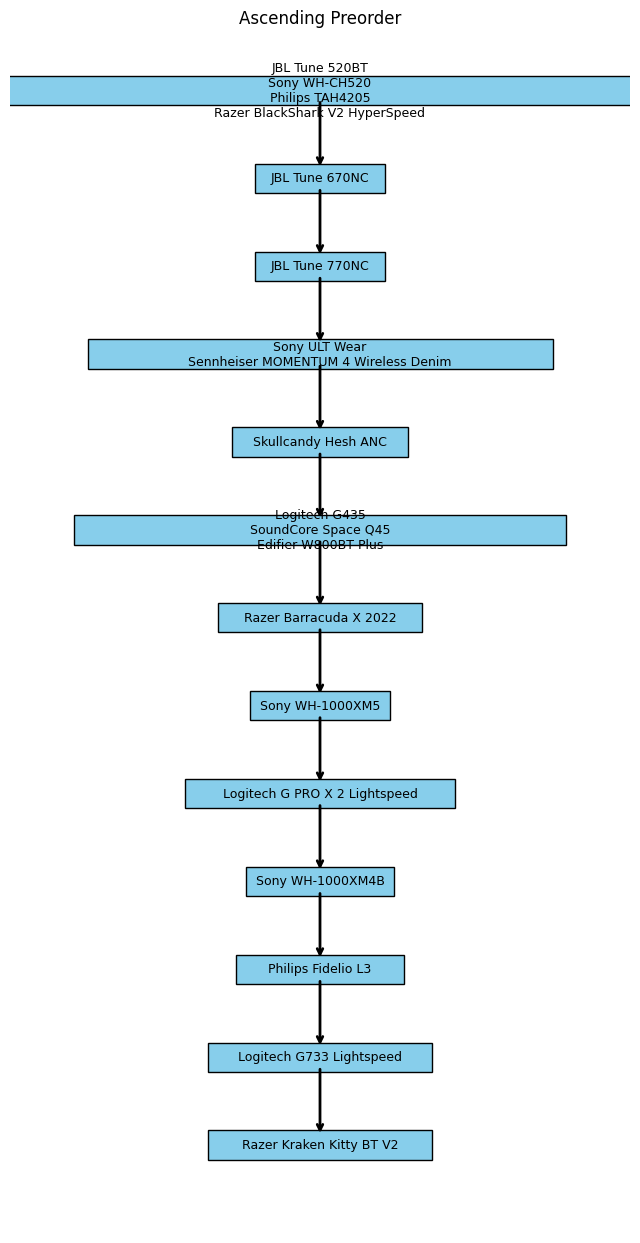

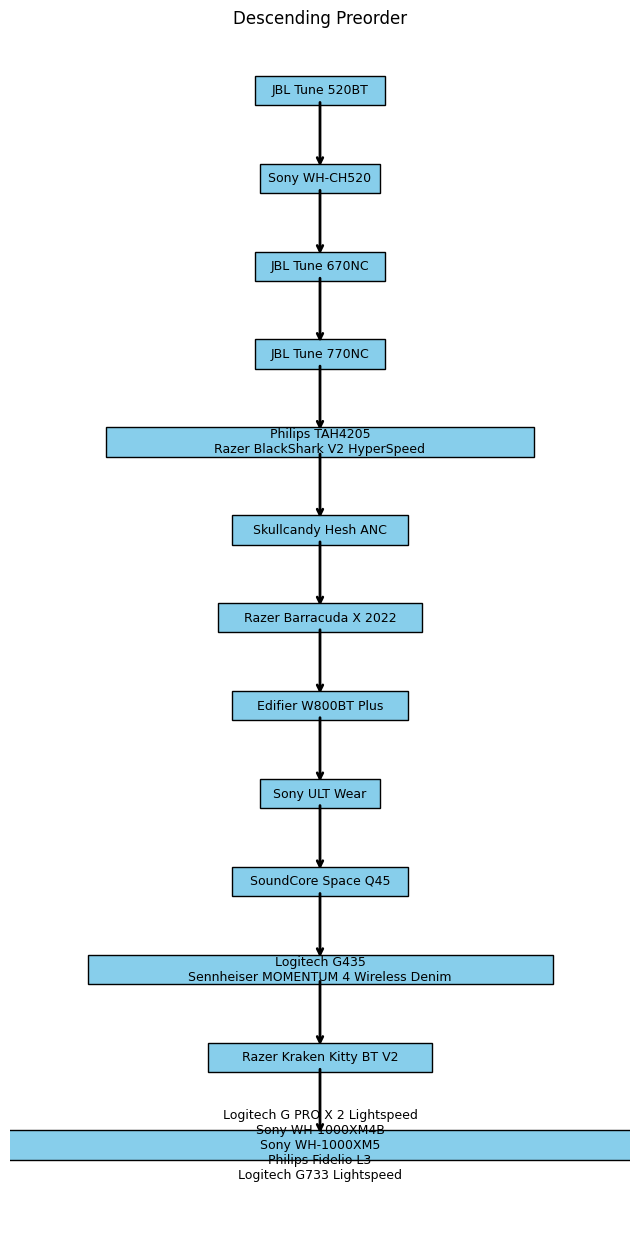

In [206]:
asc_labels_flat = flatten_with_grouping(asc_dest)
des_labels_flat = flatten_with_grouping(des_dest)

asc_values = list(range(len(asc_labels_flat)))
des_values = list(range(len(des_labels_flat)))

draw_ranking_graph('Ascending Preorder', asc_labels_grouped, asc_values[::-1], spacing=1.5)
draw_ranking_graph('Descending Preorder', des_labels_grouped, des_values[::-1], spacing=1.5)